# Monte Carlo Dropout 

## Import libraries 

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import norm


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import seaborn as sns
from matplotlib import pyplot as plt

import uncertainty_toolbox as uct

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

2022-08-22 16:19:12.598773: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 16:19:12.604246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 16:19:12.604257: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and preprocess data

In [2]:
#load data
data = pd.read_excel("../../../Data/dense_data.xlsx")
#data.head()
# Split data traning and target.
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
#preprocess data
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])

#encode data via preprocessor pipeline
X_encoded = preprocessor.fit_transform(X)
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.1)
# data shapes summary
print(f"\nDataset shape : {data.shape}")
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Dataset shape : (7314, 71)

Training Data : (6582, 426)
Testing Data  : (732, 426)



/NAS/USERS/e044432/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


## Model

In [3]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self,inputs):
        return super().call(inputs, training=True)
model = tf.keras.models.Sequential([        
			 tf.keras.layers.Dense(100,activation="relu"),
             MCDropout(0.1),
             tf.keras.layers.Dense(100,activation="relu"),
             MCDropout(0.1),
             tf.keras.layers.Dense(100,activation="relu"),
			 MCDropout(0.1),
             tf.keras.layers.Dense(10, activation="relu"),
			 MCDropout(0.1),
             tf.keras.layers.Dense(1, activation=None)
			 ])
model.compile(loss="mse", 
              optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001), 
              metrics=['mae'])

2022-08-22 16:19:26.743321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 16:19:26.743353: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 16:19:26.743376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-e044432): /proc/driver/nvidia/version does not exist
2022-08-22 16:19:26.744268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print("start training ...")
history = model.fit(X_train, y_train, epochs=150, validation_split=0.1,verbose = 0)
print("Done")
#model.summary()
#SAVE MODEL 
joblib.dump(model, "model.pkl")

start training ...
Done
INFO:tensorflow:Assets written to: ram://40830c1a-889b-4a10-8687-1aea8d1901bf/assets


['model.pkl']

### Results

#### Model Performance

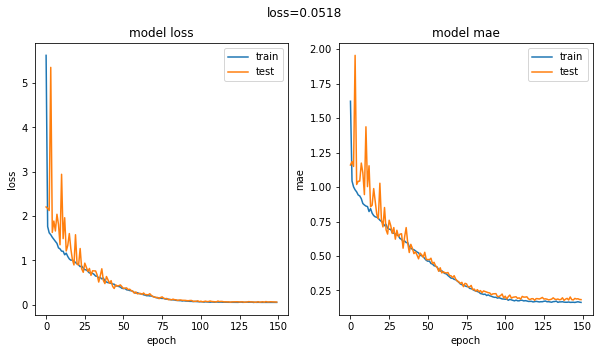

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.suptitle("loss={:5.4f}".format(history.history["loss"][-1]))

plt.show()

In [29]:
#predict output using the trained NeuralNet 
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

206/206 [==============================] - 0s 1ms/step


In [30]:
y_test = np.array(y_test)

In [31]:
# Calculate the error metrics
residuals = y_pred - y_test.reshape(-1)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mdae = median_absolute_error(y_test, y_pred)
marpd = np.abs(2 * residuals /
               (np.abs(y_pred) + np.abs(y_test.reshape(-1)))
               ).mean() * 100
r2 = r2_score(y_test, y_pred)
print("=========== Model Performance Metrics =========== ")
print(f" MAE   : {round(mae,3)} \n RMSE  : {round(rmse,3)} \n MDAE  : {round(mdae,3)} \n MARPD : {round(marpd,3)}")

=========== Model Performance Metrics =========== 
 MAE   : 0.188 
 RMSE  : 0.258 
 MDAE  : 0.141 
 MARPD : 16.478


#### Monte Carlo 

In [32]:
#make prediction using monte carlo simulation.
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)


# make 100 forward pass
y_pred_dist = predict_dist(X_test, model, 100)

In [10]:
print(f"y_pred {y_pred.shape} \ny_pred_dist {y_pred_dist.shape}")

y_pred (732, 1) 
y_pred_dist (732, 100)


In [11]:
#We have then 100 predictions, ie (y_1, y_2, ..., y_100), let's plot the mean and the variance.
prediction_distribution = y_pred_dist
prediction_mean = np.mean(np.array(prediction_distribution), axis=1)
prediction_stdv = np.std(np.array(prediction_distribution), axis=1)

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (2 * prediction_stdv)).tolist()
lower = (prediction_mean - (2 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()


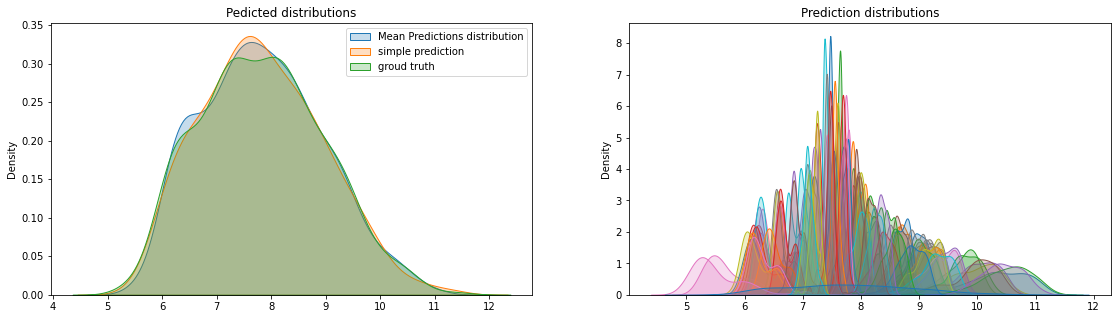

In [12]:
plt.figure(figsize=(19,5))
plt.subplot(1,2,1)
#sns.kdeplot(prediction_distribution[0], shade=True)
sns.kdeplot(prediction_mean, shade=True)
sns.kdeplot(y_pred.reshape(-1),shade=True)
sns.kdeplot(y_test, shade=True)
plt.legend(['Mean Predictions distribution','simple prediction','groud truth'])
plt.title('Pedicted distributions')
plt.subplot(1,2,2)
for i in range(len(prediction_distribution[0])):
    sns.kdeplot(prediction_distribution[i], shade=True)
    i = i+1
sns.kdeplot(prediction_mean, shade=True)
plt.title('Prediction distributions')

plt.show()

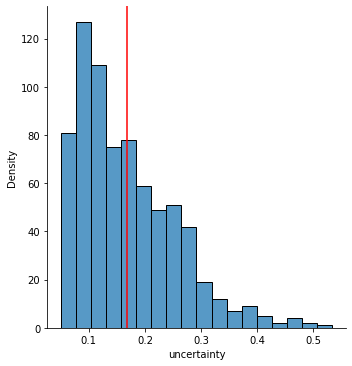

In [13]:
#plt.figure(figsize=(10,8))
sns.displot(prediction_stdv)
plt.axvline(np.mean(prediction_stdv), color='red')
#plt.legend(['mean of stdvs','std for each tire preds'])
plt.xlabel("uncertainty")
plt.ylabel("Density")
plt.show()

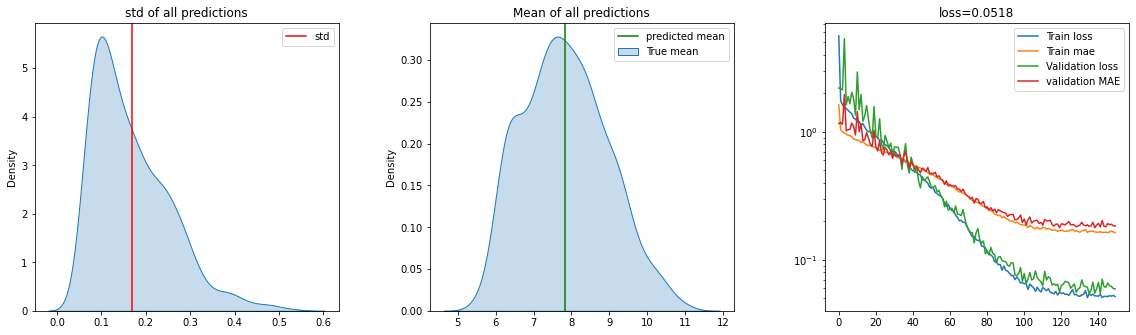

In [14]:
plt.figure(figsize=(19,5))
plt.subplot(1,3,1)
sns.kdeplot(prediction_stdv, shade=True)
plt.axvline(np.mean(prediction_stdv), color='red')
plt.title('std of all predictions')
plt.legend(['std'])

plt.subplot(1,3,2)
sns.kdeplot(prediction_mean, shade=True)
#plt.axvline(np.mean(p, color='red')
plt.axvline(np.mean(y_test), color='green')

plt.title('Mean of all predictions')
plt.legend(['predicted mean','True mean'])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

plt.subplot(1,3,3)
for key in history.history.keys():
    plt.plot(history.history[key],label=key)
plt.title("loss={:5.4f}".format(history.history["loss"][-1]))
plt.legend(['Train loss','Train mae', 'Validation loss', 'validation MAE'])
plt.yscale('log')


plt.show()

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

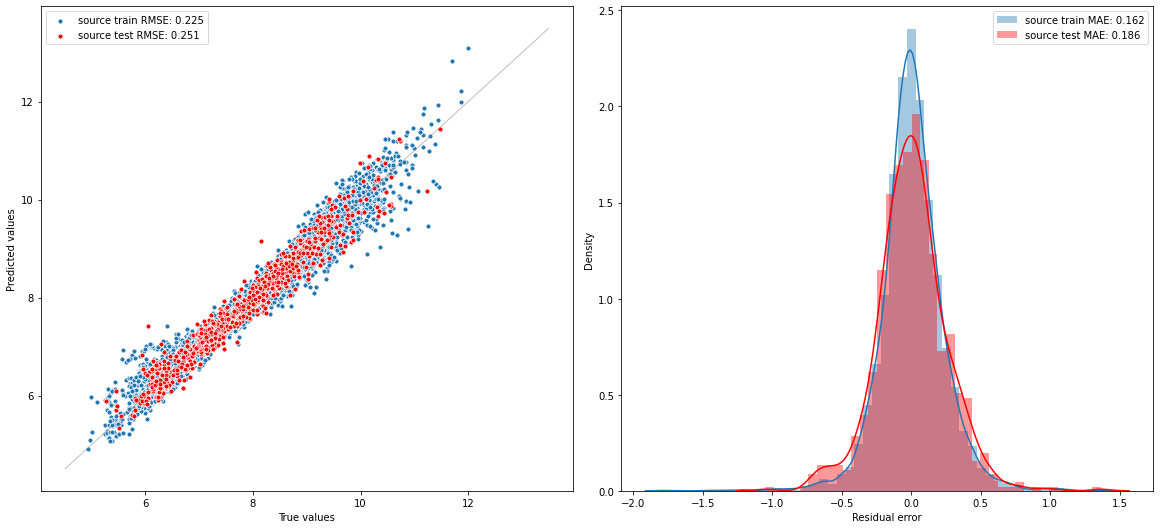

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0]);  ax3 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, y_train_pred, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, y_pred, label='source test', ax=ax1, plot_line=False,color='red', score='RMSE')


plot_residuals(y_train, y_train_pred, kind='hist', label='source train', ax=ax3, score='MAE')
plot_residuals(y_test, y_pred, kind='hist', label='source test', ax=ax3, color = 'red', score='MAE')

In [16]:
#Define validation metrics
def sharpness(std):
    return np.sqrt(np.mean(np.array(std)**2))

#Coefficient of dispersion
def dispersion(std):
    nom = np.sqrt((std - np.mean(np.array(std))**2).sum() / (len(std)-1))
    denom = np.mean(std)                 
    return nom / denom

#negative loglikelihood
def neglog(residuals, prediction_stdv):
    nll_list = []
    for (res, std) in zip(residuals, prediction_stdv):
        nll_list.append(norm.logpdf(res, scale=std))

    nll = -1 * np.sum(nll_list)
    nll = nll/len(nll_list)
    return nll

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

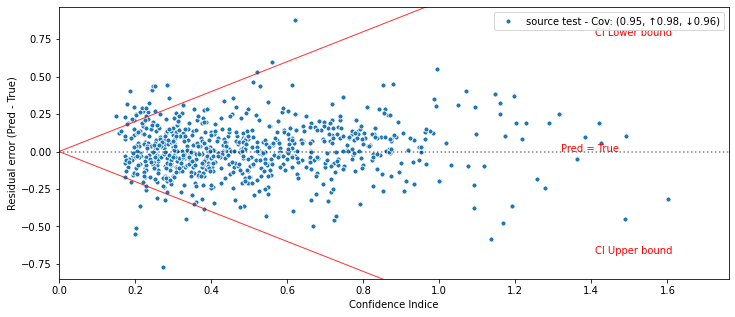

In [17]:
y_test_std = np.std(prediction_distribution, axis=1)
y_test_pred = np.mean(prediction_distribution, axis=1)
y_train_std = np.std(y_train_pred)
#plot_confidence_v2(y_train, y_train_pred, y_train_pred-2*y_train_std, y_train_pred+2*y_train_std, label='source train', cut=cut)
plot_confidence_v2(y_test,y_test_pred , y_test_pred-3*y_test_std,  y_test_pred+3*y_test_std, label='source test')

In [18]:
#Compute Metrics
sh  = sharpness(prediction_stdv)
Cv  = dispersion(prediction_stdv)
nll = neglog(residuals, prediction_stdv)

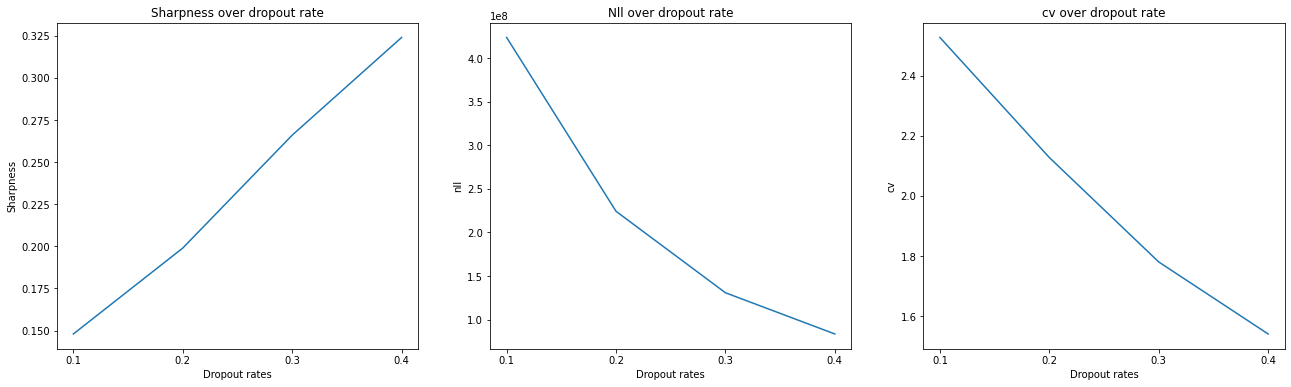

In [19]:
#Store Metrics / Dropout rate Values
sh_dropout = {"0.1":[0.148],"0.2":[0.199],"0.3":[0.266],"0.4":[0.324]}
nll_dropout = {"0.1":[423575000.993],"0.2":[224161818.856],"0.3":[130726597.904],"0.4":[83451652.502]}
Cv_dropout = {"0.1":[2.528],"0.2":[2.128],"0.3":[1.78], "0.4":[1.54]}

dropout_rates = list(sh_dropout.keys())
sh_values = list(sh_dropout.values())
nll_values = list(nll_dropout.values())
cv_values = list(Cv_dropout.values())

plt.figure(figsize=(22,6))
plt.subplot(1,3,1)
plt.plot(dropout_rates, sh_values)
plt.ylabel('Sharpness')
plt.xlabel('Dropout rates')
plt.title("Sharpness over dropout rate")

plt.subplot(1,3,2)
plt.plot(dropout_rates, nll_values)
plt.ylabel('nll')
plt.xlabel('Dropout rates')
plt.title("Nll over dropout rate")

plt.subplot(1,3,3)
plt.plot(dropout_rates, cv_values)
plt.ylabel('cv')
plt.xlabel('Dropout rates')
plt.title("cv over dropout rate")
plt.show()

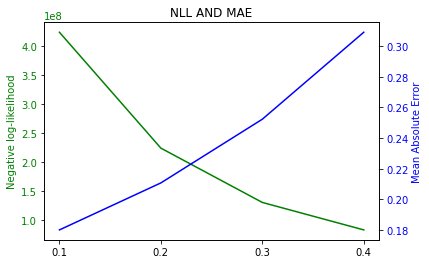

In [20]:
mae_rate = [0.18,0.2107,0.2523,0.3091]

fig, ax1 = plt.subplots() 
ax1.set_ylabel('Negative log-likelihood', color = 'green') 
ax1.plot(dropout_rates, nll_values, color = 'green') 
ax1.tick_params(axis ='y', labelcolor = 'green') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Mean Absolute Error', color = 'blue') 
ax2.plot(dropout_rates, mae_rate , color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

plt.title("NLL AND MAE")

plt.show()

======Model Parameters =====

Dropout rate : 0.2
Test size : (732, 426)
Number of layers : 9

Architecture : -> 128 128 64 32 1 ->
====== Validation Metrics ======

Sharpness : 0.18934
Dispersion : 2.22445
Negative log-likelihood : 44996.09167


/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


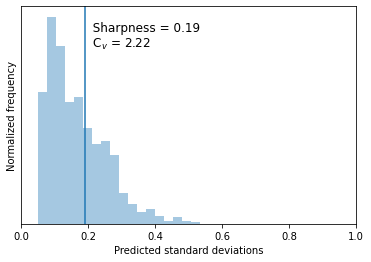

In [21]:
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=(6,4))
ax_sharp = sns.distplot(prediction_stdv, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

_ = ax_sharp.axvline(x=sh, label='sharpness')
if sh < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f \n  C$_v$ = %.2f' % (sh, Cv)
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  \nC$_v$ = %.2f  ' % (sh, Cv)
    h_align = 'right'
_ = ax_sharp.text(x=sh, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=12)


print("======Model Parameters =====")
print(f"\nDropout rate : {0.2}")
print(f"Test size : {X_test.shape}")
print(f"Number of layers : {len(model.layers)}\n")
print(f"Architecture : -> 128 128 64 32 1 ->")

print("====== Validation Metrics ======")
print(f"\nSharpness : {round(sh,5)}")
print(f"Dispersion : {round(Cv,5)}")
print(f"Negative log-likelihood : {round(nll,5)}")

In [22]:
y_pred = y_pred.reshape(732,)

## Calibration

In [23]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(prediction_mean), np.array(prediction_stdv), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(prediction_stdv))

In [24]:
np.array(y_test).shape

(732,)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

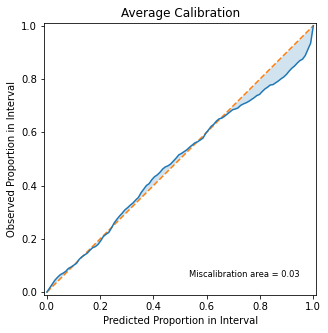

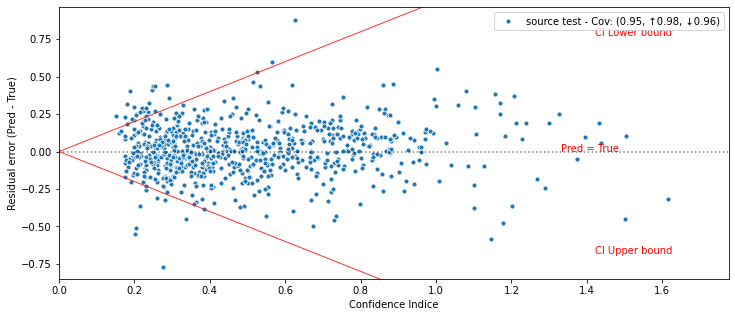

In [25]:
uct.viz.plot_calibration(np.array(prediction_mean),  np.array(new_stds) , np.array(y_test))
plot_confidence_v2(y_test,np.array(prediction_mean) ,np.array(prediction_mean)-3*new_stds, np.array(prediction_mean)+3*new_stds, label='source test')

In [26]:
metrics = uct.metrics.get_all_metrics(y_pred, np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.186
  RMSE          0.251
  MDAE          0.143
  MARPD         2.380
  R2            0.951
  Correlation   0.975
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.116
  Mean-absolute Calibration Error       0.103
  Miscalibration Area                   0.104
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.152
     Group Size: 0.56 -- Calibration Error: 0.120
     Group Size: 1.00 -- Calibration Error: 0.103
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.169
     Group Size: 0.56 -- Calibration Error: 0.136
     Group Size: 1.00 -- Calibration Error: 0.116
================

In [27]:
import pickle
with open('MCD_metrics_dense.pkl', 'wb') as f:
    pickle.dump(metrics, f)